In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support

In [4]:
#read the pickle files
not_aug_df=pd.read_pickle('EMOVO_dataset/not_aug_df.pkl')
semi_aug_df=pd.read_pickle('EMOVO_dataset/semi_aug_df.pkl')
aug_df=pd.read_pickle('EMOVO_dataset/aug_df.pkl')

scaler = StandardScaler()

In [3]:
test_df = not_aug_df.loc[not_aug_df["actor"] == "f1"]
not_aug_df = not_aug_df.drop(test_df.index)

Y_test = test_df["label_id"]
X_mfccs_k_test = np.array(test_df.iloc[:, 3:29])
X_mfccs_k_test=np.array(X_mfccs_k_test.tolist())
X_mfccs_k_test=scaler.fit_transform(X_mfccs_k_test.reshape(-1, X_mfccs_k_test.shape[-1])).reshape(X_mfccs_k_test.shape)
Y_mfccs_k_test=test_df['label']
X_logmel_test = np.array(test_df.loc[:, ['logmel' in i for i in test_df.columns]])
X_logmel_test=np.array(X_logmel_test.tolist())
X_test = np.reshape(X_logmel_test, (X_logmel_test.shape[0],X_logmel_test.shape[1],X_logmel_test.shape[2],1))
X_logmel_test = scaler.fit_transform(X_logmel_test.reshape(-1, X_logmel_test.shape[-1])).reshape(X_logmel_test.shape)


In [4]:
X_test.shape

(98, 60, 130, 1)

In [5]:
X_logmel_test.shape

(98, 60, 130)

In [6]:
len(not_aug_df)

490

In [5]:
#creation of the array containg the emotions ordered by their encoding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
sorted_labels=[]
label_encoder.fit(not_aug_df['label'])
name_mapping = dict(zip( label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
for i in range(7):
  sorted_labels.append(name_mapping[i])
sorted_labels

['anger', 'disgust', 'fear', 'joy', 'neutrality', 'sadness', 'surprise']

In [18]:
scaler = StandardScaler()
#extraction of the mfccs from the datasets - not aug
X_mfccs_k = np.array(not_aug_df.iloc[:, 3:29])
X_mfccs_k=np.array(X_mfccs_k.tolist())
X_mfccs_k=scaler.fit_transform(X_mfccs_k.reshape(-1, X_mfccs_k.shape[-1])).reshape(X_mfccs_k.shape)
Y_mfccs_k=not_aug_df['label']


#extraction of the log mel specrogram from the datasets - not aug
X_logmel_k = np.array(not_aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])
X_logmel_k=np.array(X_logmel_k.tolist())
X_logmel_k=scaler.fit_transform(X_logmel_k.reshape(-1, X_logmel_k.shape[-1])).reshape(X_logmel_k.shape)
Y_logmel_k=not_aug_df['label']

#reshape the data from 3D to 2D - not aug
X_mfccs_k=X_mfccs_k.reshape(X_mfccs_k.shape[0],X_mfccs_k.shape[1]*X_mfccs_k.shape[2])
X_logmel_k=X_logmel_k.reshape(X_logmel_k.shape[0],X_logmel_k.shape[1]*X_logmel_k.shape[2])

In [17]:
X_logmel_k = np.array(not_aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])


In [19]:
#extraction of labels_id from datasets
Y_not_aug=not_aug_df['label_id']
Y_semi_aug=semi_aug_df['label_id']
Y_aug=aug_df['label_id']


#take the log mel spectrogram from the datasets
X_logmel = np.array(not_aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])
X_logmel=np.array(X_logmel.tolist())
X_logmel_semi_aug = np.array(semi_aug_df.loc[:, ['logmel' in i for i in semi_aug_df.columns]])
X_logmel_semi_aug=np.array(X_logmel_semi_aug.tolist())
X_logmel_aug = np.array(aug_df.loc[:, ['logmel' in i for i in aug_df.columns]])
X_logmel_aug=np.array(X_logmel_aug.tolist())


#take the mfccs & deltas from the datasets
X_mfccs = np.array(not_aug_df.iloc[:, 3:29]) 
X_mfccs=np.array(X_mfccs.tolist())
X_mfccs_semi_aug = np.array(semi_aug_df.iloc[:, 3:29])
X_mfccs_semi_aug=np.array(X_mfccs_semi_aug.tolist())
X_mfccs_aug = np.array(aug_df.iloc[:, 3:29])
X_mfccs_aug=np.array(X_mfccs_aug.tolist())

In [20]:
X_logmel.shape

(588, 60, 130)

In [21]:
#add one dimension to data to make them suitable foR CNN
X_logmel = np.reshape(X_logmel, (X_logmel.shape[0],X_logmel.shape[1],X_logmel.shape[2],1))
X_logmel_semi_aug= np.reshape(X_logmel_semi_aug, (X_logmel_semi_aug.shape[0],X_logmel_semi_aug.shape[1],X_logmel_semi_aug.shape[2],1))
X_logmel_aug= np.reshape(X_logmel_aug, (X_logmel_aug.shape[0],X_logmel_aug.shape[1],X_logmel_aug.shape[2],1))

In [12]:
X_logmel.shape

(490, 60, 130, 1)

In [22]:
#CNN creation
def create_cnn(input_data):
  modelcnn = keras.Sequential()
  modelcnn.add(keras.layers.Input(shape=input_data))
  modelcnn.add(keras.layers.Conv2D(32, (2, 6), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7), strides=(2,2),padding='same'))

  modelcnn.add(keras.layers.Conv2D(64, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2,7),strides=(2,2), padding='same'))

  modelcnn.add(keras.layers.Conv2D(128, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7),strides=(2,2), padding='same'))

  modelcnn.add(keras.layers.Conv2D(256, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7),strides=(2,2), padding='same'))

 
  modelcnn.add(keras.layers.GlobalAveragePooling2D())
  modelcnn.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))

  modelcnn.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))

  modelcnn.add(keras.layers.Dense(7, activation='softmax'))
  
  return modelcnn

In [23]:
def compile_model():
    input_data=(X_logmel.shape[1:])
    modelcnn=create_cnn(input_data)
    modelcnn.compile(
    optimizer = "Adam", 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
    )
    return modelcnn
def train_val_test(X,Y):
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=22)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)
    return X_train,X_val,X_test,y_train,y_val,y_test

def get_accuracy(X_test,y_test, modelcnn):
    predicted = modelcnn.predict(X_test)

    preds = []
    for prediction in predicted:
        preds.append(np.argmax(prediction))

    print(accuracy_score(y_test,preds))


In [15]:
from datetime import datetime  
name = datetime.now().strftime("ser_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=1,
        monitor="val_loss"),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=20,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]
modelcnn = compile_model()

modelcnn.summary()

X_train,X_val,X_test,y_train,y_val,y_test = train_val_test(X_logmel,Y_not_aug)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 59, 125, 32)       416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 58, 64)        24640     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 24, 128)       98432     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 12, 128)        0

In [16]:



history = modelcnn.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=256,
                       epochs=1000,
                       #callbacks=callbacks
                       )

Epoch 1/1000
2/2 [==============================] - 2s 463ms/step - loss: 2.5029 - accuracy: 0.1506 - val_loss: 2.4705 - val_accuracy: 0.2022
Epoch 2/1000
2/2 [==============================] - 1s 317ms/step - loss: 2.4395 - accuracy: 0.2330 - val_loss: 2.4273 - val_accuracy: 0.2360
Epoch 3/1000
2/2 [==============================] - 1s 316ms/step - loss: 2.3720 - accuracy: 0.2415 - val_loss: 2.3814 - val_accuracy: 0.2360
Epoch 4/1000
2/2 [==============================] - 1s 317ms/step - loss: 2.3031 - accuracy: 0.2557 - val_loss: 2.3606 - val_accuracy: 0.2247
Epoch 5/1000
2/2 [==============================] - 1s 300ms/step - loss: 2.3172 - accuracy: 0.2358 - val_loss: 2.3411 - val_accuracy: 0.2247
Epoch 6/1000
2/2 [==============================] - 1s 283ms/step - loss: 2.2590 - accuracy: 0.2585 - val_loss: 2.2958 - val_accuracy: 0.2584
Epoch 7/1000
2/2 [==============================] - 1s 312ms/step - loss: 2.2603 - accuracy: 0.2415 - val_loss: 2.2799 - val_accuracy: 0.2247
Epoch 

KeyboardInterrupt: 

In [16]:
get_accuracy(X_test,y_test,modelcnn)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0.4489795918367347


In [24]:
modelcnn = compile_model()

X_train,X_val,X_test,y_train,y_val,y_test = train_val_test(X_logmel_semi_aug,Y_semi_aug)

In [25]:
from datetime import datetime  
name = datetime.now().strftime("ser_semiaug_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    # keras.callbacks.ModelCheckpoint(
    #     filepath = name,
    #     save_best_only=True,
    #     verbose=1,
    #     monitor="val_loss"),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=20,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]

history_semi = modelcnn.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=256,
                       epochs=1000,
                       callbacks=callbacks)

Epoch 1/1000
5/5 [==============================] - 6s 879ms/step - loss: 2.4777 - accuracy: 0.1489 - val_loss: 2.4110 - val_accuracy: 0.2075
Epoch 2/1000
5/5 [==============================] - 4s 810ms/step - loss: 2.3475 - accuracy: 0.2356 - val_loss: 2.3324 - val_accuracy: 0.2516
Epoch 3/1000
5/5 [==============================] - 4s 792ms/step - loss: 2.2675 - accuracy: 0.2348 - val_loss: 2.2441 - val_accuracy: 0.2547
Epoch 4/1000
5/5 [==============================] - 4s 794ms/step - loss: 2.1934 - accuracy: 0.2545 - val_loss: 2.1866 - val_accuracy: 0.2579
Epoch 5/1000
5/5 [==============================] - 4s 779ms/step - loss: 2.1392 - accuracy: 0.2671 - val_loss: 2.1407 - val_accuracy: 0.2673
Epoch 6/1000
5/5 [==============================] - 4s 783ms/step - loss: 2.0828 - accuracy: 0.2774 - val_loss: 2.0992 - val_accuracy: 0.2673
Epoch 7/1000
5/5 [==============================] - 4s 795ms/step - loss: 2.0372 - accuracy: 0.2790 - val_loss: 2.0609 - val_accuracy: 0.2642
Epoch 

In [33]:
y_train_ = np.array(y_train)

In [35]:
from TSInterpret.InterpretabilityModels.counterfactual.NativeGuideCF import NativeGuideCF

exp_model=NativeGuideCF(modelcnn,(X_train,y_train_), backend='TF', mode='time',method='NUN_CF')

ValueError: in user code:

    File "c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\engine\training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\engine\training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\engine\training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\engine\training.py", line 2357, in predict_step
        return self(x, training=False)
    File "c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 60, 130, 1), found shape=(None, 130, 1)


In [19]:
get_accuracy(X_test,y_test,modelcnn)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0.8305084745762712


In [27]:
modelcnn = compile_model()

X_train,X_val,X_test,y_train,y_val,y_test = train_val_test(X_logmel_aug,Y_aug)

In [28]:
np.save("X_train", X_train)
np.save("X_test", X_test)
np.save("Y_train", y_train)
np.save("Y_test", y_test)


In [29]:
from datetime import datetime  
name = datetime.now().strftime("ser_aug_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    # keras.callbacks.ModelCheckpoint(
    #     filepath = name,
    #     save_best_only=True,
    #     verbose=1,
    #     monitor="val_loss",
    #     options=None),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.01,
        patience=10,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]


history_semi = modelcnn.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=256,
                       epochs=1000,
                       callbacks=callbacks
                       )

Epoch 1/1000
7/7 [==============================] - 5s 618ms/step - loss: 2.4479 - accuracy: 0.1726 - val_loss: 2.3451 - val_accuracy: 0.2123
Epoch 2/1000
7/7 [==============================] - 4s 575ms/step - loss: 2.3032 - accuracy: 0.2311 - val_loss: 2.2378 - val_accuracy: 0.2311
Epoch 3/1000
7/7 [==============================] - 4s 581ms/step - loss: 2.2205 - accuracy: 0.2335 - val_loss: 2.1667 - val_accuracy: 0.2476
Epoch 4/1000
7/7 [==============================] - 4s 584ms/step - loss: 2.1408 - accuracy: 0.2524 - val_loss: 2.1179 - val_accuracy: 0.2665
Epoch 5/1000
7/7 [==============================] - 4s 588ms/step - loss: 2.0806 - accuracy: 0.2553 - val_loss: 2.0412 - val_accuracy: 0.2547
Epoch 6/1000
7/7 [==============================] - 5s 681ms/step - loss: 2.0354 - accuracy: 0.2801 - val_loss: 2.0478 - val_accuracy: 0.2500
Epoch 7/1000
7/7 [==============================] - 5s 689ms/step - loss: 1.9870 - accuracy: 0.2949 - val_loss: 1.9407 - val_accuracy: 0.3019
Epoch 

In [30]:
get_accuracy(X_test,y_test,modelcnn)

8/8 [==============================] - 0s 29ms/step
0.7966101694915254


In [17]:
modelcnn = tf.keras.models.load_model('ser_aug_25_09_2024_11_06_25.keras')

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 60, 130, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_2'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [40]:
y_test_ = np.array(y_test)

In [42]:
int(np.argmax(y_test_[0]))

0

In [47]:
import pickle
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as snst
import sklearn.preprocessing
from tslearn.datasets import UCR_UEA_datasets
import tensorflow as tf 
import sklearn
# Load data.
dataset='BasicMotions'
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(train_y.reshape(-1,1))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))




In [39]:
y_test_ = np.array(y_test)

In [40]:
y_test_[0]

5

In [51]:
train_x.shape[-2], train_x.shape[-1], train_x.shape

(100, 6, (40, 100, 6))

In [60]:
X_train.shape[-1]

1

In [41]:
from TSInterpret.InterpretabilityModels.Saliency.TSR import TSR
int_mod=TSR(modelcnn, X_train.shape[-3],X_train.shape[-2], method='GRAD',mode='time')
item= np.array([X_test[0,:,:]])
# label=int(np.argmax(y_test[0]))   
label=int(y_test_[0])

exp=int_mod.explain(item,labels=label,TSR =True)



Mode in TF Saliency time


True
time mode


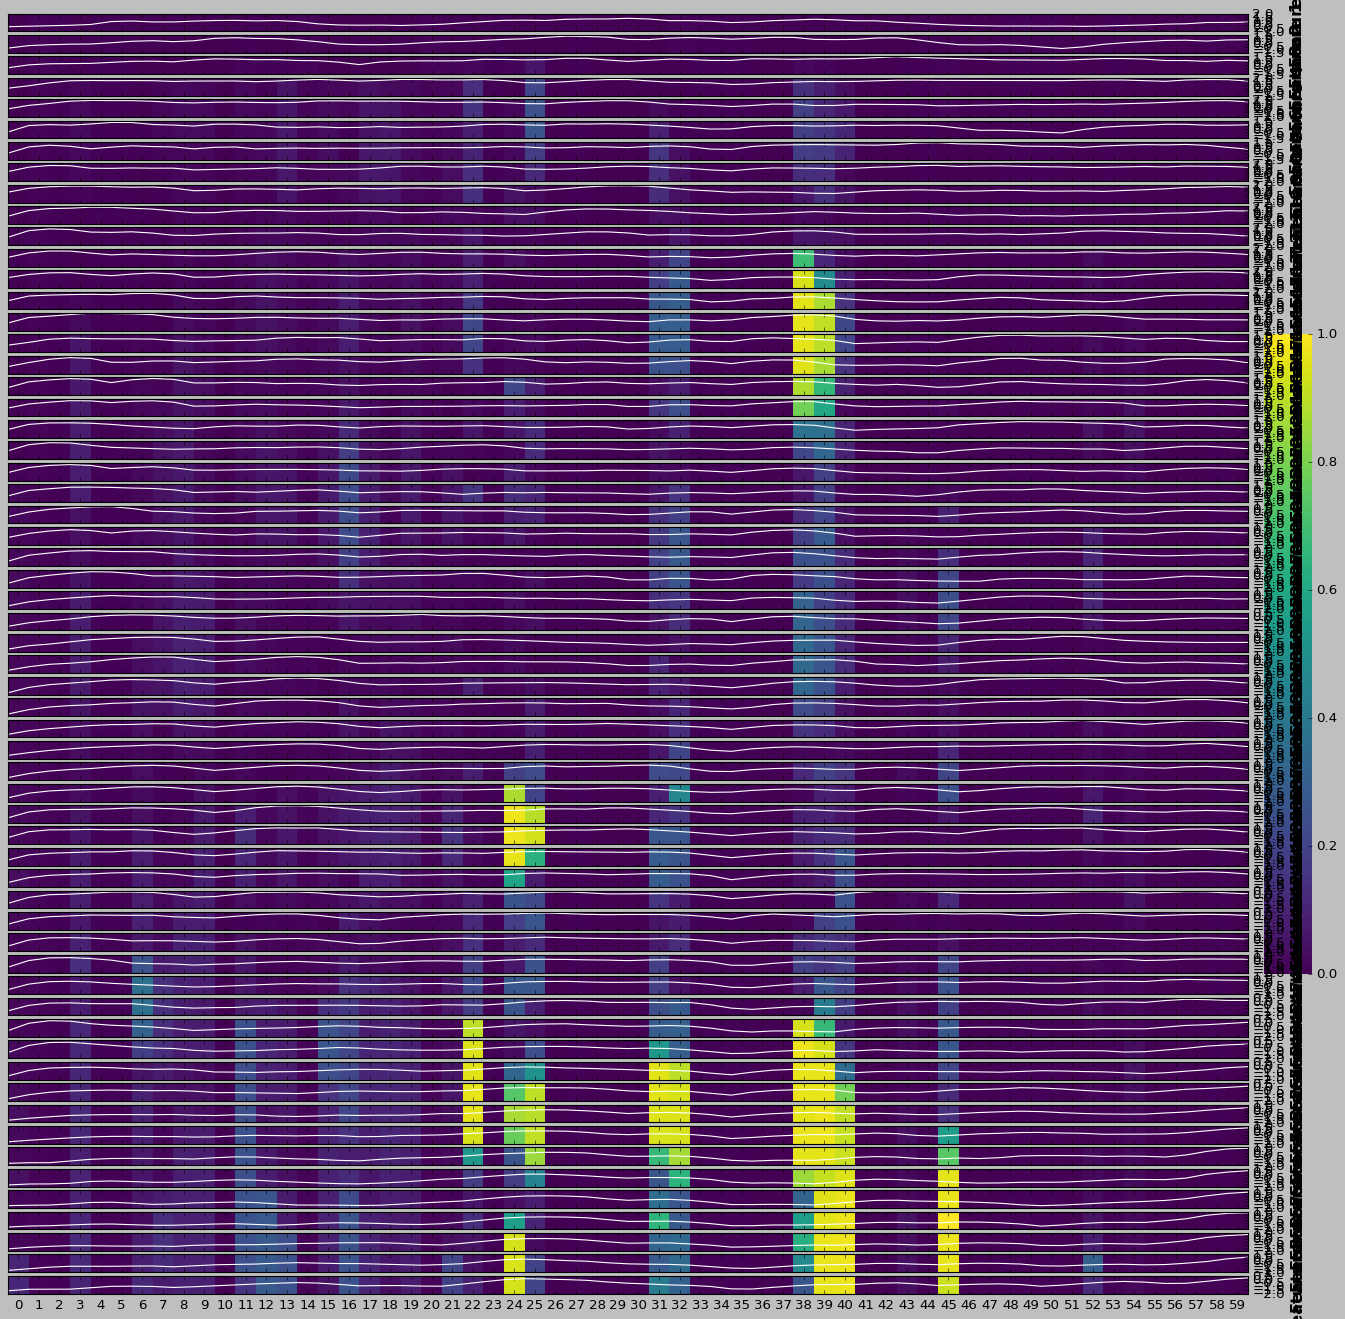

In [46]:
int_mod.plot(np.array([X_test[0,:,:]]),exp, figsize=(20, 20), save="plot.png")

In [76]:
X_train_ = X_train.squeeze(-1)

In [77]:
from TSInterpret.InterpretabilityModels.counterfactual.SETSCF import SETSCF
exp_model= SETSCF(modelcnn,
                  (X_train_, y_train),
                  backend='TF',
                  mode='time',  
                  min_shapelet_len=3,
                  max_shapelet_len=20,
                  time_contract_in_mins_per_dim=1,
                  #initial_num_shapelets_per_case=10,
                  fit_shapelets = False)

Extract Shapelets with information gain rejection lvl 0.001 and shapelets per class of 30


KeyboardInterrupt: 

In [ ]:
ts = 5
y_test_[ts]
cf_explanation, label = exp_model.explain(np.swapaxes(X_test[ts],0,1), target = None)

In [ ]:
exp_model.plot(
        cf_explanation,
        np.argmax(modelcnn(data[2])[ts]),
        test_x[ts],
        label,
        vis_change=True,
        all_in_one=False,
        save_fig=None,
        figsize=(6.4, 4.8))

In [70]:
exp = exp_model.explain(item)


AttributeError: Exception encountered when calling layer 'sequential_3' (type Sequential).

'torch.Size' object has no attribute 'rank'

Call arguments received by layer 'sequential_3' (type Sequential):
  • inputs=tensor([[[1.4067, 1.4067, 1.4067,  ..., 1.4067, 1.4067, 1.4067],
         [1.4067, 1.4067, 1.4067,  ..., 1.4067, 1.4067, 1.4067],
         [1.4067, 1.4067, 1.4067,  ..., 1.4067, 1.4067, 1.4067],
         ...,
         [1.4067, 1.4067, 1.4067,  ..., 1.4067, 1.4067, 1.4067],
         [1.4067, 1.4067, 1.4067,  ..., 1.4067, 1.4067, 1.4067],
         [1.4067, 1.4067, 1.4067,  ..., 1.4067, 1.4067, 1.4067]]])
  • training=None
  • mask=None

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras import layers, models


In [13]:
X_train,X_val,X_test,y_train,y_val,y_test = train_val_test(X_logmel,Y_not_aug)
X_train.shape

(423, 60, 130, 1)

In [21]:
def get_model():
    inputs = layers.Input(shape=(60,130))
    encoder = layers.LSTM(128)(inputs)
    drop = layers.Dropout(0.3)(encoder)
    hidden = layers.Dense(32, activation='relu')(drop)
    outputs = layers.Dense(7, activation='softmax')(hidden)
    
    model = models.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

    return model

In [22]:
X_train,X_val,X_test,y_train,y_val,y_test = train_val_test(X_logmel.squeeze(3),Y_not_aug)
LSTM_model = get_model()
LSTM_model.summary()



Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 130)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       132,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,967 (535.03 KB)

 Trainable params: 136,967 (535.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

from datetime import datetime  
name = datetime.now().strftime("ser_lstm_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=1,
        monitor="val_loss"),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=20,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]


LSTM_history = LSTM_model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=32,
                       epochs=1000,
                       verbose=1,
                       callbacks=callbacks)


print(f"Loss : {LSTM_model.evaluate(X_test,y_test)[0]}, Accuracy : {LSTM_model.evaluate(X_test,y_test)[1]}")

In [16]:
X_train,X_val,X_test,y_train,y_val,y_test = train_val_test(X_logmel_semi_aug.squeeze(3),Y_semi_aug)
LSTM_model = get_model()
LSTM_model.summary()


from datetime import datetime  
name = datetime.now().strftime("ser_lstm_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=1,
        monitor="val_loss"),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=20,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]


LSTM_history = LSTM_model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=32,
                       epochs=1000,
                       verbose=1,
                       callbacks=callbacks)


print(f"Loss : {LSTM_model.evaluate(X_test,y_test)[0]}, Accuracy : {LSTM_model.evaluate(X_test,y_test)[1]}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 130)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       132,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,967 (535.03 KB)

 Trainable params: 136,967 (535.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1587 - loss: 1.9887
Epoch 1: val_loss improved from inf to 1.83600, saving model to ser_lstm_11_09_2024_11_22_52.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.1605 - loss: 1.9855 - val_accuracy: 0.2453 - val_loss: 1.8360
Epoch 2/1000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2819 - loss: 1.7779
Epoch 2: val_loss improved from 1.83600 to 1.76401, saving model to ser_lstm_11_09_2024_11_22_52.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2826 - loss: 1.7774 - val_accuracy: 0.2767 - val_loss: 1.7640
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3741 - loss: 1.6249
Epoch 3: val_loss improved from 1.76401 to 1.61461, saving model to ser_lstm_11_09_2024_11_22_52.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3734 - loss: 1.6253 - val_accuracy: 0.3962 - val_loss: 1.6146
Epoch 4/1000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4221 - loss: 1.5032

In [17]:
X_train,X_val,X_test,y_train,y_val,y_test = train_val_test(X_logmel_aug.squeeze(3),Y_aug)
LSTM_model = get_model()
LSTM_model.summary()


from datetime import datetime  
name = datetime.now().strftime("ser_lstm_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=1,
        monitor="val_loss"),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=20,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]


LSTM_history = LSTM_model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=32,
                       epochs=1000,
                       verbose=1,
                       callbacks=callbacks)


print(f"Loss : {LSTM_model.evaluate(X_test,y_test)[0]}, Accuracy : {LSTM_model.evaluate(X_test,y_test)[1]}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 130)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       132,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,967 (535.03 KB)

 Trainable params: 136,967 (535.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1691 - loss: 1.9619
Epoch 1: val_loss improved from inf to 1.82668, saving model to ser_lstm_11_09_2024_11_24_36.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.1699 - loss: 1.9606 - val_accuracy: 0.2901 - val_loss: 1.8267
Epoch 2/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2912 - loss: 1.8070
Epoch 2: val_loss improved from 1.82668 to 1.69720, saving model to ser_lstm_11_09_2024_11_24_36.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2913 - loss: 1.8065 - val_accuracy: 0.3443 - val_loss: 1.6972
Epoch 3/1000
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3720 - loss: 1.6195
Epoch 3: val_loss improved from 1.69720 to 1.54907, saving model to ser_lstm_11_09_2024_11_24_36.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3722 - loss: 1.6184 - val_accuracy: 0.4198 - val_loss: 1.5491
Epoch 4/1000
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4454 - loss: 1.4739

In [23]:
from sklearn.svm import SVC
X_train,X_val,X_test,y_train,y_val,y_test = train_val_test(X_logmel.squeeze(3),Y_not_aug)
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)


SVC_model = SVC(kernel = 'rbf', gamma = 'auto', probability = True, verbose=True)



In [24]:
print(SVC_model)

SVC(gamma='auto', probability=True, verbose=True)


In [ ]:

SVC_history = SVC_model.fit(X_train, y_train)

print(f"Accuracy : {accuracy_score(SVC_model.predict(X_test),np.array(y_test))}")

In [19]:
from sklearn.svm import SVC
X_train,X_val,X_test,y_train,y_val,y_test = train_val_test(X_logmel_semi_aug.squeeze(3),Y_semi_aug)
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)


SVC_model = SVC(kernel = 'rbf', gamma = 'auto', probability = True, verbose=True)


SVC_history = SVC_model.fit(X_train, y_train)

print(f"Accuracy : {accuracy_score(SVC_model.predict(X_test),np.array(y_test))}")

[LibSVM]Accuracy : 0.6384180790960452


In [20]:
from sklearn.svm import SVC
X_train,X_val,X_test,y_train,y_val,y_test = train_val_test(X_logmel_aug.squeeze(3),Y_aug)
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)


SVC_model = SVC(kernel = 'rbf', gamma = 'auto', probability = True, verbose=True)


SVC_history = SVC_model.fit(X_train, y_train)

print(f"Accuracy : {accuracy_score(SVC_model.predict(X_test),np.array(y_test))}")

[LibSVM]Accuracy : 0.7966101694915254
